In [1]:
cd ..

/Users/huttercl/Documents/StrokeRecovery/CorrelationGraph4Stroke_public


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from StrokeRecovery import utils
from StrokeRecovery import interactionmodel as IM
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import signal, stats
import scikit_posthocs as posthoc
import statsmodels.api as sm

change_version = 'v1.6'

plt.rcParams["font.family"] = utils.get_config()['plot_params']['font']
plt.rcParams['font.size'] = utils.get_config()['plot_params']['font_size']

In [3]:
def s_categories(suffix):
    return list([c + suffix for c in utils.categories()]) 

In [4]:
patients = pd.read_excel('data/ds2a_patients_{}.xlsx'.format(change_version), index_col=[0])
limos = pd.read_excel('data/ds2b_limos_{}.xlsx'.format(change_version), index_col=[0,1])

In [5]:
def get_entry_exit_limos(rlimos):
    cats = utils.categories()
    rlimos['sum_limos'] = rlimos[cats].sum(axis=1)
    
    entry = rlimos.xs('a_ESN', level=1)
    exit = rlimos.xs('g_ASN', level=1)

    assert np.all(entry.index == exit.index)

    rlimos_entry_exit = pd.merge(entry, exit, left_index=True, right_index=True, suffixes=['_entry', '_exit'])
    return rlimos_entry_exit

limos_entry_exit = get_entry_exit_limos(limos)
with_limos = pd.merge(patients, limos_entry_exit, left_index=True, right_index=True)

In [6]:

def infra_vs_supra_map(loclabel):
    if loclabel == "Right":
        return "supra"
    elif loclabel == "Left":
        return "supra"
    elif loclabel == "BS":
        return "infra"
    else:
        raise ValueError('dont know if {} is infra or supra'.format(loclabel))
        
with_limos['infra_or_supra']= with_limos['loc_label'].map(infra_vs_supra_map)

# Statistical Tests

In [7]:
def stats_comparison(df, group_column_name, stats_callable, colnames):
    """
        df (pd.DataFrame)
        group_column_name (str): the name of the column based on which to stratify 
        stats_callable (func): a callable (from scikit) that returns a p-value 
        colnames List[str]: list of columns in df on which to perform the test
        return pd.Series, index=limos scale, values=p-values
    """
    
    group_names = np.unique(df[group_column_name].values)
    
    groups = list()
    for g in group_names:
        this_group = df[df[group_column_name]==g]
        groups.append(this_group)
        
    collector = dict()
    for limos_scale in colnames:   
        these_columns = list(g[limos_scale].values for g in groups)
        
        result = stats_callable(*these_columns)
        statistic, pvalue = result
        
        collector[limos_scale] = pvalue
        
        
    name = "{}:{}".format(group_column_name, stats_callable.__name__)
    
    result_series =  pd.Series(collector)
    result_series.name = name
    return result_series


def table_of_stats(df, list_of_tests, colnames):
    """
        df: pd.DataFrame
        list_of_tests: list[Tuple2<str, callable>], list of tests to do, with the column to split by and the test as a callable
    """
    collector = list()
    for name, func in list_of_tests:
        out = stats_comparison(df, group_column_name=name, stats_callable=func, colnames=colnames)
        collector.append(out)
        
    return pd.concat(collector, axis=1)


def vis_significance(df, alpha=0.5):
    def highlight_sig(val, alpha):
        if pd.isnull(val):
            color= '' 
        elif val <= alpha:
            color = '#A3E4D7'  
        else:
            color = '#D35400' # Pastel blue
        return 'background-color: {}'.format(color)

    return df.style.format(formatter="{:.5f}", na_rep='').applymap(highlight_sig, alpha=alpha)




In [8]:
instructions = [
    ('loc_label', stats.kruskal),
    ('loc_label', stats.f_oneway),
    ('infra_or_supra', stats.kruskal),
    ('infra_or_supra', stats.mannwhitneyu), #for two samples both tests are the same
]
overview_table = table_of_stats(with_limos, instructions, colnames =  s_categories("_entry")) # + s_categories("_exit"))

sig_table = vis_significance(overview_table, 0.05/7) # Bonferonni correction for 7 comparrissons
sig_table.to_excel('figs/stats.xlsx')
sig_table

,loc_label:kruskal,loc_label:f_oneway,infra_or_supra:kruskal,infra_or_supra:mannwhitneyu
InterpersInteraction_entry,0.00084,0.00061,0.00093,0.00093
Mobility_entry,0.00354,0.00261,0.63529,0.63550
Selfcare_entry,0.00037,0.00040,0.00318,0.00318
Communication_entry,0.00000,0.00000,0.00000,0.00000
LearningKnowledge_entry,0.00000,0.00000,0.00000,0.00000
Generaltasks_entry,0.00000,0.00000,0.00000,0.00000
DomesticLife_entry,0.00011,0.00009,0.00027,0.00027


In [9]:
def posthoc_table(values, val_col, group_col):
    ph = posthoc.posthoc_dunn(with_limos, val_col=val_col, group_col = group_col)
    
    n, n1 = ph.values.shape
    assert n == n1
    
    tonull_i, tonull_j = np.tril_indices(n)
    
    ph.values[tonull_i, tonull_j] = np.nan
    
    ph2 = ph.dropna(axis=0, how='all').dropna(axis=1, how='all') # remove non-informative rows and columns
    
    return ph2

def posthoc_table_all_categories(values, group_col):
    categories = s_categories('_entry') 
    
    collector = list()
    
    for cat in categories:
        ph_this = posthoc_table(values, val_col=cat, group_col=group_col)
        n = len(ph_this)
        
        ph2 = ph_this.set_index([[cat]*n, ph_this.index]).rename_axis(['Category', ''])
        collector.append(ph2)
        
    final_table = pd.concat(collector)
    return final_table

In [10]:
posthoc_loc = vis_significance(posthoc_table_all_categories(with_limos,  group_col='loc_label'), 0.05/3)
posthoc_loc.to_excel('figs/posthoc_loc.xlsx')
posthoc_loc

/var/folders/xg/gkggmsps5gg5f4096x7z8chh0000gn/T/ipykernel_24541/1404709833.py:2: CSSWarning: Unhandled color format: ''
  posthoc_loc.to_excel('figs/posthoc_loc.xlsx')


In [11]:
with_limos['loc_label'].value_counts()

Left     274
Right    198
BS       120
Name: loc_label, dtype: int64

In [12]:
category_rename_dict = {key+"_entry": val for key, val in utils.get_category_rename_dict(linebreaks=True).items()}

diag_rename_dict = utils.get_diag_rename_dict()
loc_rename_dict = utils.get_loc_rename_dict()


In [13]:
def overview_plot(group_col, levels, list_of_cols_to_test, df=with_limos, stats_callable=stats.kruskal, figsize= None, xrename_dict=None, yrename_dict=None):
    if figsize is None:
        width = utils.get_config()['plot_params']['paper_width']
        height = width*0.6
        figsize = (width, height)
    dpi = utils.get_config()['plot_params']['dpi']
    selection= df[df[group_col].isin(levels)]
    selection2 = selection[list_of_cols_to_test+[group_col]]
    
    
    
    for_plot = selection2.melt(id_vars=group_col)
    if yrename_dict is not None:
        for_plot[group_col] = for_plot[group_col].map(lambda d: yrename_dict[d])
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    lw = utils.get_config()['plot_params']['box_plot_linewidth']
    sb.boxplot(data=for_plot, x='variable', y='value', hue=group_col, ax=ax, linewidth = lw, fliersize=2*lw )
    plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
    ax.set_xlabel('ICF-domain')
    ax.set_ylabel('ICF-domain score')
    
    if stats_callable is not None:
        stats_result = stats_comparison(df = selection2, group_column_name=group_col, stats_callable=stats_callable, colnames=list_of_cols_to_test)
        
        current_labels = ax.xaxis.get_ticklabels()
        new_labels = list()
        for l in current_labels:
            text = l.get_text()
            

            
            significance = stats_result.loc[text]
            if significance < (0.01/7):
                to_append = '**'
            elif significance < (0.05/7):
                to_append = '*'
            else:
                to_append = ''
                
            if xrename_dict is not None:
                new_label = xrename_dict[text]
            else:
                new_label = text
            
            new_text = new_label + to_append
            l.set_text(new_text)
            new_labels.append(l)
        ax.xaxis.set_ticklabels(new_labels)
        
    ax.set_yticks(np.arange(1, 6, 1))
        
    legend = ax.get_legend()
    legend.set_title('')
    plt.legend(loc='upper right')

    
    return fig

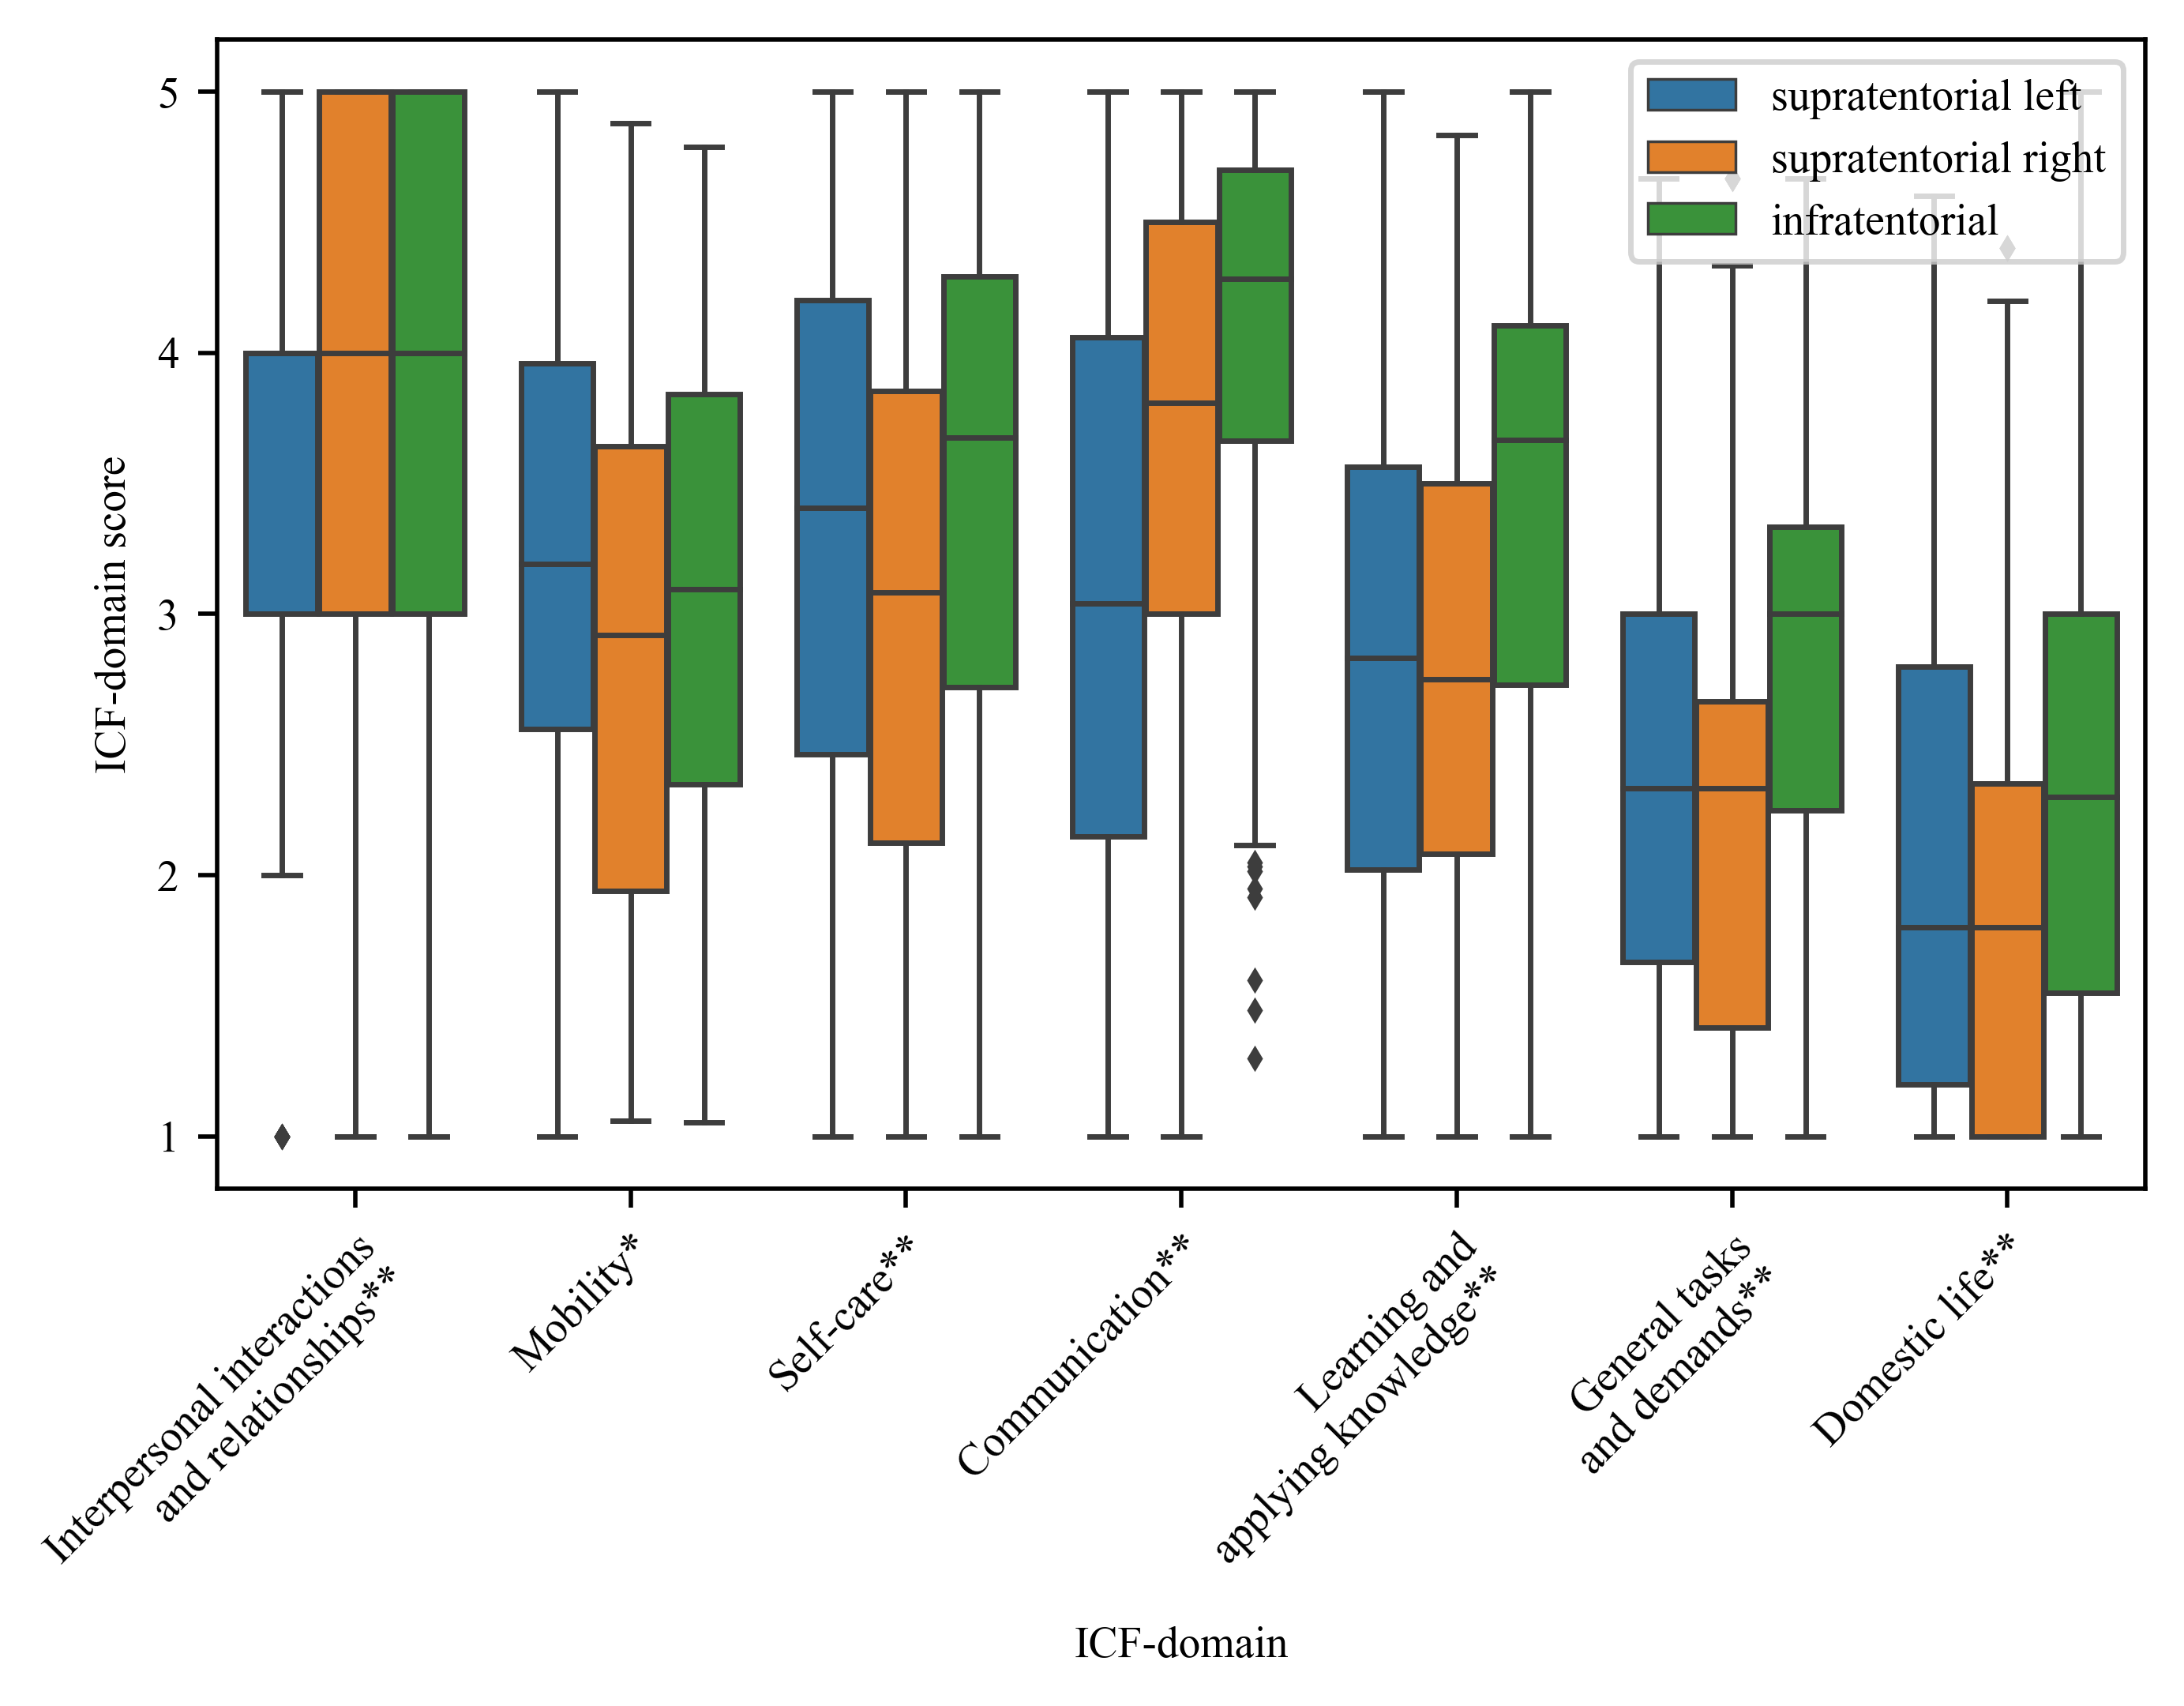

In [14]:
loc_fig = overview_plot('loc_label', ['Left', 'Right', 'BS'], s_categories("_entry"), df=with_limos, 
                        xrename_dict=category_rename_dict, 
                        yrename_dict=loc_rename_dict)
loc_fig.savefig('figs/loc_label_entry_new.pdf', bbox_inches='tight')

# Summary table

In [15]:
def nihhs_map(val):
    try:
        intval = int(val)
    except ValueError:
        return np.nan # if its not an explicit number, the value is missing. Marked as n in the excel.

    return intval


with_limos['NIHHS'] = with_limos['NIHHSnachLyseThrombek_SN'].map(nihhs_map)

In [16]:
sstat = utils.SummaryStatistics(with_limos)

In [17]:
instructions = [ # name of column; name of row in summary; type of aggregate to compute; extra keyword arguments
    ('age', 'Characteristic', 'count'),
    ('age', 'Age, years, mean (sd)' , 'meanSd'),
    ('Geschlecht_SN', 'Gender, N (%)', 'percentages', dict(rename={1: 'female', 2: 'male'})),
    ('entry_N_days_after_stroke', 'Time poststroke, days, (quartile 1, quartile 3)', 'percentiles'),
    ('duration_of_stay', 'Length of stay, days, median (quartile 1, quartile 3)', 'percentiles'),
    ('NIHHS', 'NIHSS, points, median (quartile 1, quartile 3)', 'percentiles'),
    ('diag_label', 'Stroke artery supply, N (%)', 'percentages', dict(rename=utils.get_diag_rename_dict())),
    ('loc_label', 'Stroke localization region, N (%)', 'percentages', dict(rename=utils.get_loc_rename_dict())),
    ('n_measurements', 'number of measurements, N (%)', 'percentages') 
]
lim_cats = utils.categories()

_limos_summary_instructions_raw = [(cat, sstat.tab_characters + utils.get_category_rename_dict()[cat], 'percentiles') for cat in lim_cats] + [('sum_limos', sstat.tab_characters+ 'Total Score', 'percentiles')]

limos_entry_instructions = ['LIMOS at admission, median (q1-q3)'] + [ (inst[0]+"_entry",) + inst[1:] for inst in _limos_summary_instructions_raw]
limos_exit_instructions = ['LIMOS at exit, median (q1-q3)'] + [ (inst[0]+"_exit",) + inst[1:] for inst in _limos_summary_instructions_raw]

instructions += (limos_entry_instructions + limos_exit_instructions)

In [18]:
patients_statistics = pd.DataFrame(data = {
    'Patients' : sstat.get_overview_table(instructions)
})

In [19]:
patients_statistics

,Patients
Characteristic,N=592
"Age, years, mean (sd)",71.7 (14.365)
"Gender, N (%)",.
female,267 (45.1%)
male,324 (54.7%)
"Time poststroke, days, (quartile 1, quartile 3)",8.0 (6.0 - 10.0)
"Length of stay, days, median (quartile 1, quartile 3)",28.0 (19.0 - 40.0)
"NIHSS, points, median (quartile 1, quartile 3)","4.0 (2.0 - 8.0), 12.5% missing values"
"Stroke artery supply, N (%)",.
ACA,28 (4.7%)
